# Survey Data

Survey Questions:
1. From a scale 1 to 5, how popular is this city? (1 is the least popular and 5 is the most popular)
2. On a scale of 1 to 5, how efficient is this city at turning everyday occurrences into potential viral moments on social media? (1 is the least efficient and 5 is the most efficient)
3. Rate the city's architectural uniqueness from 1 to 5, with 5 being a blend of futuristic wonder and historical charm.
4. Rate the city's enthusiasm for spontaneous street parties on a scale of 1 to 5, with 5 being the life of the celebration.
5. If you were to travel to this city, who would be likely with you?
6. Rank the following words from the least to most relatable to this city. Each area should have a different number assigned to it. (1 is the least relatable and 6 is the most relatable)
7. In your opinion, what is the average temperature of this city over the month of January? (Specify your answer in Celsius)
8. How many different languages might you overhear during a stroll through the city?
9. How many different fashion styles might you spot within a 10-minute walk in the city?
10. What quote comes to mind when you think of this city?

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import random
from itertools import product

from google.colab import drive
import sys
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Inspecting the data
data = pd.read_csv("/content/gdrive/MyDrive/CSC311/clean_dataset.csv")
data.describe(include="all")

,id,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Label
count,1468.000000,1462.000000,1461.000000,1461.000000,1462.000000,1461,1468,1461,1461.000000,1461,1419,1468
unique,NaN,NaN,NaN,NaN,NaN,15,806,58,NaN,41,1231,4
top,NaN,NaN,NaN,NaN,NaN,"Partner,Friends","Skyscrapers=>1,Sport=>5,Art and Music=>4,Carni...",25,NaN,5,The city that never sleeps,Dubai
freq,NaN,NaN,NaN,NaN,NaN,264,31,163,NaN,264,12,367
mean,459092.092643,4.321477,3.521561,3.707734,3.391929,NaN,NaN,NaN,4.796030,NaN,NaN,NaN
std,114308.717089,0.884464,1.192031,1.142037,1.297189,NaN,NaN,NaN,22.142305,NaN,NaN,NaN
min,5978.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,406181.000000,4.000000,3.000000,3.000000,2.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN
50%,503173.000000,5.000000,4.000000,4.000000,3.000000,NaN,NaN,NaN,3.000000,NaN,NaN,NaN
75%,522169.000000,5.000000,5.000000,5.000000,5.000000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN


In [3]:
# Check if the data is balanced
print(data['Label'].value_counts())

Label
Dubai             367
Rio de Janeiro    367
New York City     367
Paris             367
Name: count, dtype: int64


# Data Vectorization

1. Scalar: 1-5
2. Scalar: 1-5
3. Scalar: 1-5
4. Scalar: 1-5
5. Indicator vector: [Partner, Friends, Sibilings, Co-worker]
6. Ordinal encoding: [Skyscrapers, Sport, Art and Music, Carnival, Cuisine, Economic]
7. Scalar: Real number
8. Scalar: Natural number
9. Scalar: Natural number
10. BOW indicator encoding (excluded for now)

In [4]:
# Helper functions
def to_numeric(s):
  """Converts string `s` to a float.

  Invalid strings and NaN values will be converted to 0.
  """
  if isinstance(s, str):
    s = s.replace(",", '')
    s = pd.to_numeric(s, errors="coerce")
  return float(s)


def get_number_list(s):
  """Get a list of integers contained in string `s`
  """
  return [int(n) for n in re.findall(r"(\d+)", str(s))]

def get_number(s):
  """Get the first number contained in string `s`.

  If `s` does not contain any numbers, return 0.
  """
  n_list = get_number_list(s)
  return n_list[0] if len(n_list) >= 1 else 0

def cat_in_s(s, cat):
  """Return if a category is present in string `s` as an binary integer.
  """
  return int(cat in s) if not pd.isna(s) else 0

def get_cat_ranking(s, cat):
  ranks = s.split(",")

  for r in ranks:
    if cat in r:
      return get_number(r)

  raise Exception("Error get_cat_ranking: invalid category")

def clean_quote(s):
  if isinstance(s, float):
    return ''

  lower = s.lower()
  parse_white_space = re.sub(r'\s+', ' ', lower)
  final = re.sub(r'[^a-z ]', '', parse_white_space)

  return final

def is_word_in_s(s, word):
    return int(word in clean_quote(s))

def get_permutations_with_replacement(elements, n):
  """
  Generate all permutations of `elements` of size `n` with replacement.

  Parameters:
  - elements: List of integers.
  - n: Size of each permutation.

  Returns:
  - List of tuples, each tuple is a permutation of `n` elements.
  """
  return list(product(elements, repeat=n))

# So we can see the data without it being truncated
pd.set_option('display.max_colwidth', None)

In [ ]:
import re

# get vocab
vocab_dict = {}

for line in data['Q10']:
  if isinstance(line, float):
    continue

  lower = line.lower()
  parse_white_space = re.sub(r'\s+', ' ', lower)
  final = re.sub(r'[^a-z ]', '', parse_white_space)

  words = final.split()
  for word in words:
      if word not in vocab_dict:
          vocab_dict[word] = 0
      else:
          vocab_dict[word] += 1

vocab = list(vocab_dict.keys())
print(vocab)
print("Vocabulary Size: ", len(vocab))
print(f"Data size: {len(data)}")

quotes = data['Q10']
bow = make_bow(quotes, vocab)

vocab_count_mapping = list(zip(vocab, np.sum(bow, axis=0)))
vocab_count_mapping = sorted(vocab_count_mapping, key=lambda e: e[1], reverse=True)
for word, cnt in vocab_count_mapping:
    print(word, cnt)

['slavery', 'wherever', 'there', 'is', 'great', 'property', 'inequality', 'futuristic', 'land', 'the', 'city', 'where', 'anything', 'possible', 'if', 'you', 'can', 'think', 'of', 'a', 'high', 'building', 'it', 'probably', 'exists', 'in', 'dubai', 'technology', 'tallest', 'world', 'will', 'never', 'settle', 'for', 'less', 'than', 'third', 'place', 'so', 'much', 'to', 'discover', 'rich', 'nice', 'was', 'best', 'times', 'worst', 'i', 'barely', 'know', 'about', 'this', 'one', 'belongs', 'new', 'york', 'instantly', 'as', 'five', 'minutes', 'years', 'just', 'keep', 'swimming', 'with', 'skyscraper', 'burj', 'khalifa', 'want', 'deal', 'your', 'problems', 'by', 'becoming', 'warm', 'skyscrapers', 'sand', 'habibi', 'come', 'desert', 'welcome', 'future', 'middle', 'nowhere', 'ammazing', 'spectacular', 'money', 'make', 'go', 'round', 'black', 'gold', 'dreams', 'reach', 'heights', 'food', 'here', 'expensive', 'people', 'gather', 'im', 'state', 'mind', 'western', 'countries', 'are', 'dying', 'growing

NameError: name 'make_bow' is not defined

In [5]:
from sklearn.preprocessing import normalize

# Process and vectorize the data. Here we are using all features except the Q10
data_fets = np.stack([
    data['Q1'].apply(to_numeric).fillna(0),
    data['Q2'].apply(to_numeric).fillna(0),
    data['Q3'].apply(to_numeric).fillna(0),
    data['Q4'].apply(to_numeric).fillna(0),
    data['Q5'].apply(lambda s: cat_in_s(s, "Partner")),
    data['Q5'].apply(lambda s: cat_in_s(s, "Friends")),
    data['Q5'].apply(lambda s: cat_in_s(s, "Siblings")),
    data['Q5'].apply(lambda s: cat_in_s(s, "Co-worker")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Skyscrapers")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Sport")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Art and Music")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Carnival")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Cuisine")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Economic")),
    data['Q7'].apply(to_numeric).fillna(0),
    # data['Q8'].apply(to_numeric).fillna(0),
    # data['Q9'].apply(to_numeric).fillna(0),
    data['Q10'].apply(lambda s: is_word_in_s(s, "dubai")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "rich")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "city")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "rio")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "love")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "dreams")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "paris")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "york")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "football")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "tower")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "concrete")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "money")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "baguette")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "brazil")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "carnival")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "jungle")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "eiffel")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "habibi")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "oil")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "big")),
    data['Q10'].apply(lambda s: is_word_in_s(s, "apple")),
], axis=1)

data_norm = normalize(data_fets, axis=0, norm='max')

data_label = np.array(data["Label"])

cleaned_temp = np.stack([
    data['Q1'].apply(to_numeric).fillna(0),
    data['Q2'].apply(to_numeric).fillna(0),
    data['Q3'].apply(to_numeric).fillna(0),
    data['Q4'].apply(to_numeric).fillna(0),
    data['Q5'].apply(lambda s: cat_in_s(s, "Partner")),
    data['Q5'].apply(lambda s: cat_in_s(s, "Friends")),
    data['Q5'].apply(lambda s: cat_in_s(s, "Siblings")),
    data['Q5'].apply(lambda s: cat_in_s(s, "Co-worker")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Skyscrapers")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Sport")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Art and Music")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Carnival")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Cuisine")),
    data['Q6'].apply(lambda s: get_cat_ranking(s, "Economic")),
    data['Q7'].apply(to_numeric).fillna(0),
    data['Q8'].apply(to_numeric).fillna(0),
    data['Q9'].apply(to_numeric).fillna(0),
    np.array(data["Label"])
], axis=1)

cleaned_df = pd.DataFrame(cleaned_temp.tolist(), columns=["Q1", "Q2", "Q3", "Q4", "Q5-1", "Q5-2", "Q5-3", "Q5-4", "Q6-1", "Q6-2", "Q6-3", "Q6-4", "Q6-5", "Q6-6", "Q7", "Q8", "Q9", "Label"])

print(data_fets[3])

[ 5.  4.  4.  1.  1.  1.  0.  0.  6.  5.  1.  2.  4.  3. 23.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [ ]:
# Comparing an unprocessed data point and its processed counter part
random_index = random.randint(0, len(data))
print("### Unprocessed ###")
print(data.iloc[random_index])

print("\n### Processed ###")
print(f"Q1: {data_fets[random_index][0]}")
print(f"Q2: {data_fets[random_index][1]}")
print(f"Q3: {data_fets[random_index][2]}")
print(f"Q4: {data_fets[random_index][3]}")
print(f"Q5: Partner={data_fets[random_index][4]}, Friends={data_fets[random_index][5]}, Siblings={data_fets[random_index][6]}, Co-worker={data_fets[random_index][7]}")
print(f"Q6: Skyscrapers=>{data_fets[random_index][8]}, Sport=>{data_fets[random_index][9]}, Art and Music=>{data_fets[random_index][10]}, Carnival=>{data_fets[random_index][11]}, Cuisine=>{data_fets[random_index][12]}, Economic=>{data_fets[random_index][13]}")
print(f"Q7: {data_fets[random_index][14]}")
print(f"Q8: {data_fets[random_index][15]}")
print(f"Q9: {data_fets[random_index][16]}")
print()

# We have 367 respondents in the survey. Each respondent contributed 4 data vectors
print(f"\nShape of processed data{data_fets.shape}")  # Should be (1,468, D)

### Unprocessed ###
id                                                                            385647
Q1                                                                               5.0
Q2                                                                               5.0
Q3                                                                               2.0
Q4                                                                               4.0
Q5                                                         Partner,Friends,Co-worker
Q6       Skyscrapers=>5,Sport=>3,Art and Music=>2,Carnival=>1,Cuisine=>4,Economic=>6
Q7                                                                                22
Q8                                                                               1.0
Q9                                                                                 3
Q10                                                                            Fancy
Label                                        

# Data Exploration

Here we will explore the data to assess the quality of each feature.

In [ ]:
dubai = cleaned_df[cleaned_df['Label'] == 'Dubai']
rdj = cleaned_df[cleaned_df['Label'] == 'Rio de Janeiro']
nyc = cleaned_df[cleaned_df['Label'] == 'New York City']
paris = cleaned_df[cleaned_df['Label'] == 'Paris']

def get_stats(q, mm=True, boxplot=True, outliers=True):
  print(f"Statistics for {q}")
  if mm:
    print(f"Dubai:\t\t\tmean={dubai.loc[:, q].mean()}, median={dubai.loc[:, q].median()}")
    print(f"Rio de Janeiro:\t\tmean={rdj.loc[:, q].mean()}, median={rdj.loc[:, q].median()}")
    print(f"New York City:\t\tmean={nyc.loc[:, q].mean()}, median={nyc.loc[:, q].median()}")
    print(f"Paris:\t\t\tmean={paris.loc[:, q].mean()}, median={paris.loc[:, q].median()}")
  if boxplot:
    cleaned_df.boxplot(column = q, by = "Label", showfliers=False).get_figure().suptitle('Boxplot grouped by Label (Without outliers)')
    if outliers:
      cleaned_df.boxplot(column = q, by = "Label", showfliers=outliers).get_figure().suptitle('Boxplot grouped by Label (With outliers)')


<Axes: xlabel='Label', ylabel='Q8'>

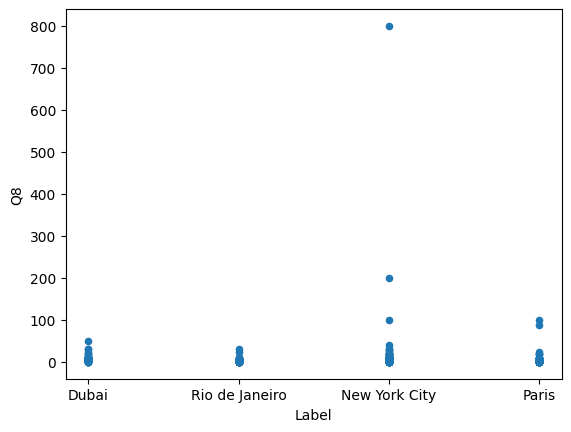

In [ ]:
# pd.plotting.scatter_matrix(cleaned_df.loc[:, ["Q1", "Q2", "Label"]])

cleaned_df.plot.scatter(x="Label", y='Q8')

Statistics for Q1
Dubai:			mean=4.23433242506812, median=4.0
Rio de Janeiro:		mean=3.5395095367847413, median=4.0
New York City:		mean=4.782016348773842, median=5.0
Paris:			mean=4.659400544959128, median=5.0


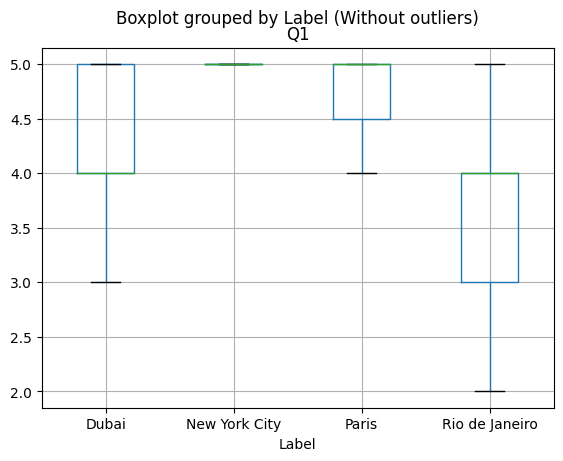

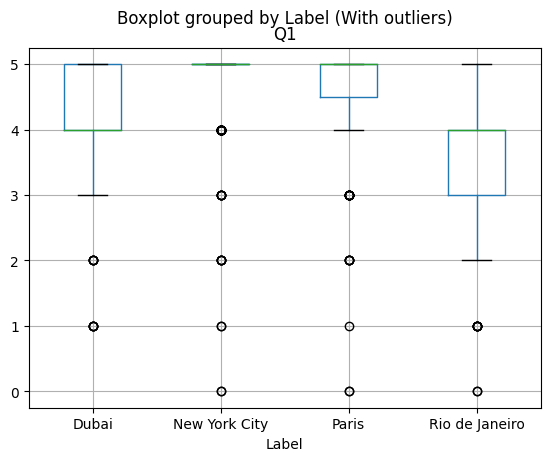

In [ ]:
# Q1: Popularity
get_stats("Q1")

Statistics for Q2
Dubai:			mean=3.4059945504087192, median=4.0
Rio de Janeiro:		mean=2.8419618528610355, median=3.0
New York City:		mean=4.430517711171662, median=5.0
Paris:			mean=3.3405994550408717, median=3.0


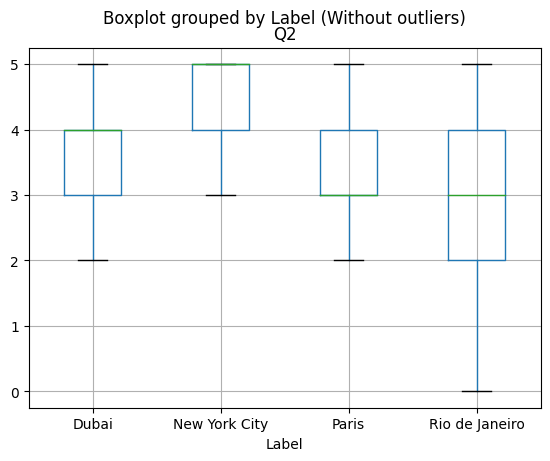

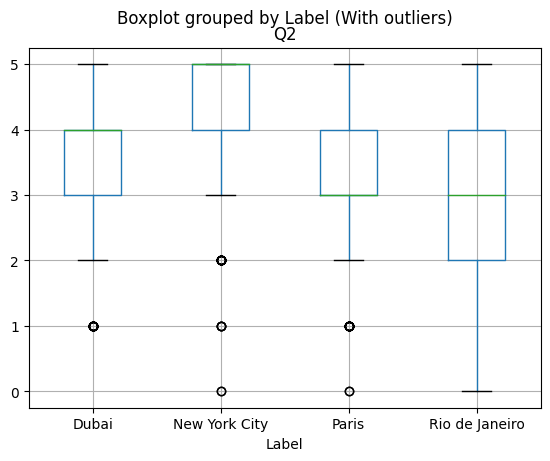

In [ ]:
# Q2: Viralness
get_stats("Q2")

Statistics for Q3
Dubai:			mean=4.0272479564032695, median=4.0
Rio de Janeiro:		mean=3.0790190735694822, median=3.0
New York City:		mean=3.4523160762942777, median=4.0
Paris:			mean=4.201634877384196, median=4.0


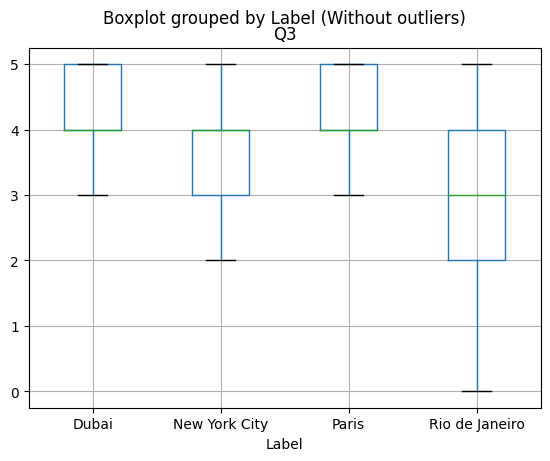

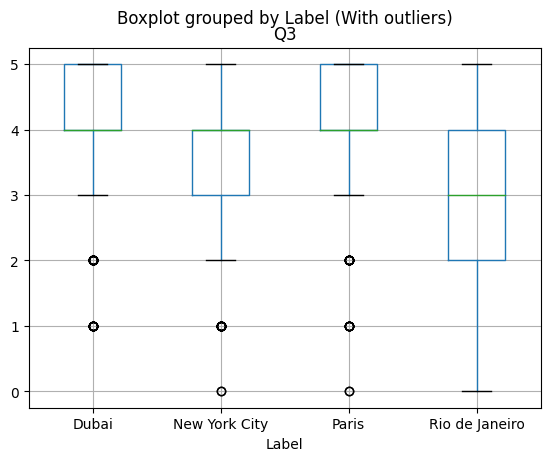

In [ ]:
# Q3: Architectural Uniqueness
get_stats("Q3")

Statistics for Q4
Dubai:			mean=2.768392370572207, median=3.0
Rio de Janeiro:		mean=4.433242506811989, median=5.0
New York City:		mean=3.2752043596730247, median=3.0
Paris:			mean=3.035422343324251, median=3.0


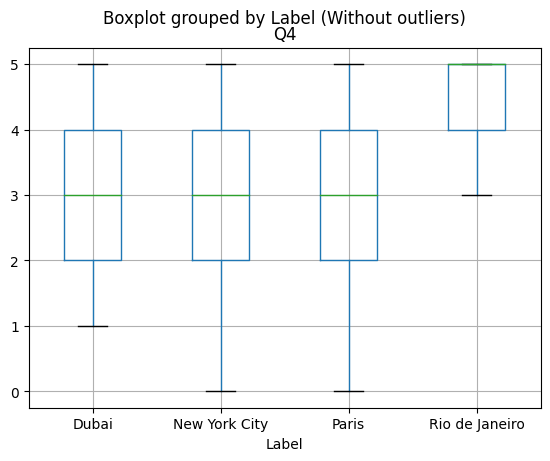

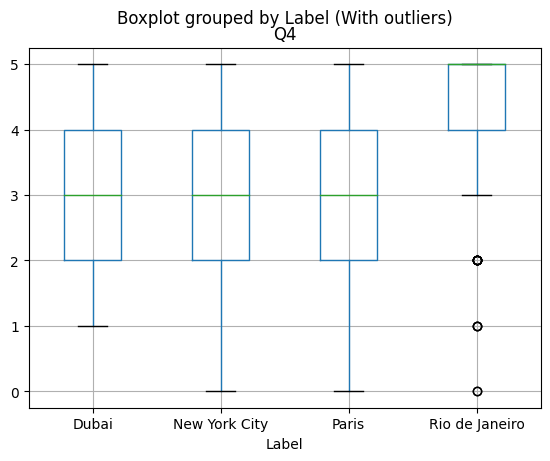

In [ ]:
# Q4
get_stats("Q4")

Statistics for Q5-1
Dubai:			mean=0.5340599455040872, median=1.0
Rio de Janeiro:		mean=0.5831062670299727, median=1.0
New York City:		mean=0.6348773841961853, median=1.0
Paris:			mean=0.8610354223433242, median=1.0

### Partner Count (Out of 367) ###
 Dubai: 196, Rio de Janeiro: 214, New York City: 233, Paris: 316


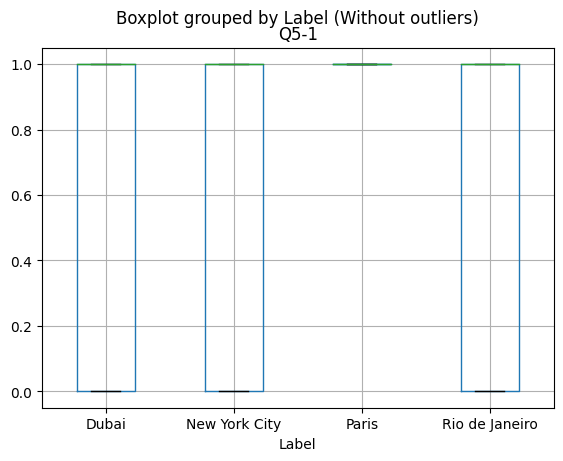

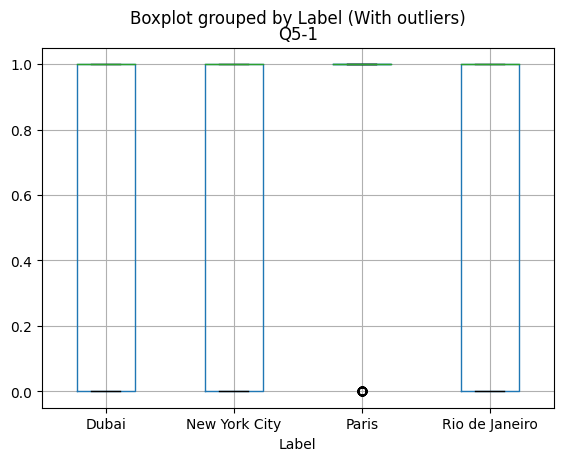

In [ ]:
# Q5 Partner
get_stats("Q5-1")
print(f"\n### Partner Count (Out of {int(cleaned_df.loc[:, 'Q5-1'].count() / 4)}) ###\n Dubai: {dubai.loc[:, 'Q5-1'].sum()}, Rio de Janeiro: {rdj.loc[:, 'Q5-1'].sum()}, New York City: {nyc.loc[:, 'Q5-1'].sum()}, Paris: {paris.loc[:, 'Q5-1'].sum()}")

Statistics for Q5-2
Dubai:			mean=0.7683923705722071, median=1.0
Rio de Janeiro:		mean=0.8310626702997275, median=1.0
New York City:		mean=0.7874659400544959, median=1.0
Paris:			mean=0.5013623978201635, median=1.0

### Friend Count (Out of 367) ###
 Dubai: 282, Rio de Janeiro: 305, New York City: 289, Paris: 184


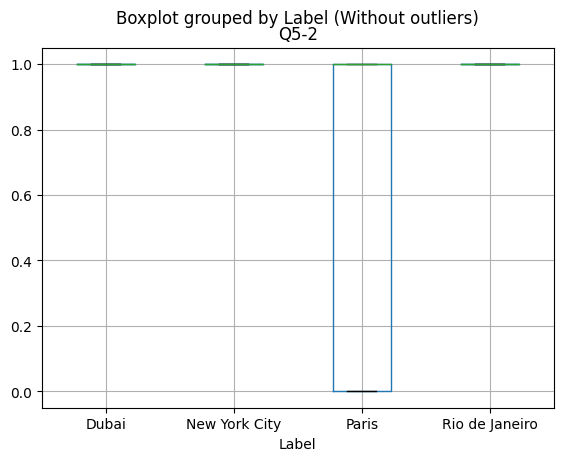

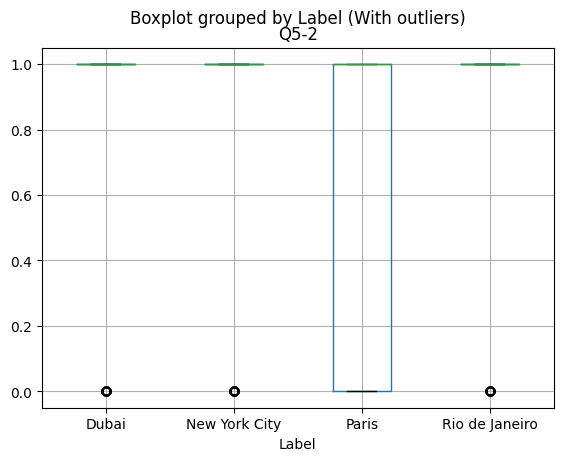

In [ ]:
# Q5 Friends
get_stats("Q5-2")
print(f"\n### Friend Count (Out of {int(cleaned_df.loc[:, 'Q5-2'].count() / 4)}) ###\n Dubai: {dubai.loc[:, 'Q5-2'].sum()}, Rio de Janeiro: {rdj.loc[:, 'Q5-2'].sum()}, New York City: {nyc.loc[:, 'Q5-2'].sum()}, Paris: {paris.loc[:, 'Q5-2'].sum()}")

Statistics for Q5-3
Dubai:			mean=0.3460490463215259, median=0.0
Rio de Janeiro:		mean=0.3188010899182561, median=0.0
New York City:		mean=0.5613079019073569, median=1.0
Paris:			mean=0.3242506811989101, median=0.0

### Silbings Count (Out of 367) ###
 Dubai: 127, Rio de Janeiro: 117, New York City: 206, Paris: 119


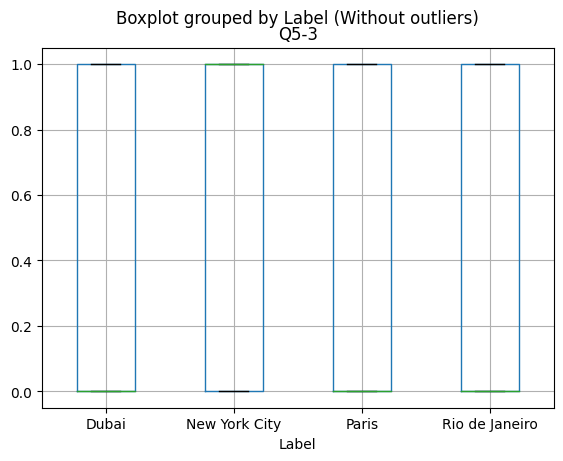

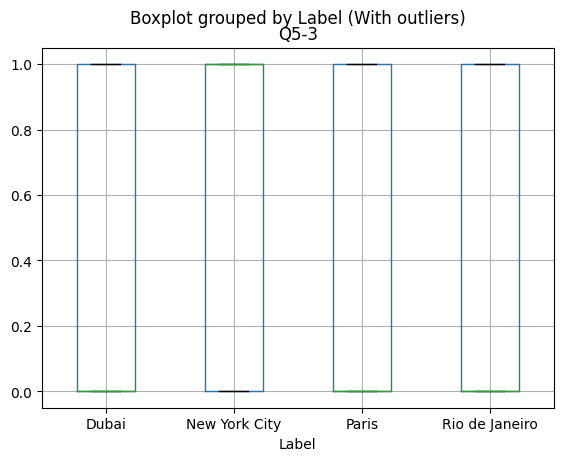

In [ ]:
# Q5 Silbings
get_stats("Q5-3")
print(f"\n### Silbings Count (Out of {int(cleaned_df.loc[:, 'Q5-3'].count() / 4)}) ###\n Dubai: {dubai.loc[:, 'Q5-3'].sum()}, Rio de Janeiro: {rdj.loc[:, 'Q5-3'].sum()}, New York City: {nyc.loc[:, 'Q5-3'].sum()}, Paris: {paris.loc[:, 'Q5-3'].sum()}")


Statistics for Q5-4
Dubai:			mean=0.23978201634877383, median=0.0
Rio de Janeiro:		mean=0.08719346049046321, median=0.0
New York City:		mean=0.5776566757493188, median=1.0
Paris:			mean=0.11444141689373297, median=0.0

### Co-Worker Count (Out of 367) ###
 Dubai: 88, Rio de Janeiro: 32, New York City: 212, Paris: 42


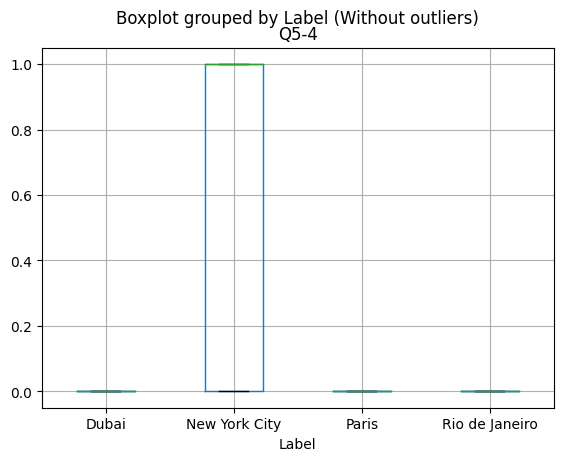

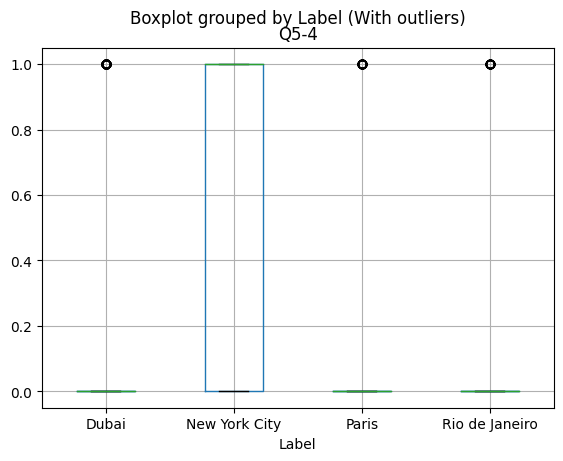

In [ ]:
# Q5 Co-worker
get_stats("Q5-4")
print(f"\n### Co-Worker Count (Out of {int(cleaned_df.loc[:, 'Q5-4'].count() / 4)}) ###\n Dubai: {dubai.loc[:, 'Q5-4'].sum()}, Rio de Janeiro: {rdj.loc[:, 'Q5-4'].sum()}, New York City: {nyc.loc[:, 'Q5-4'].sum()}, Paris: {paris.loc[:, 'Q5-4'].sum()}")


Statistics for Q6-1
Dubai:			mean=5.539509536784741, median=6.0
Rio de Janeiro:		mean=1.7411444141689374, median=1.0
New York City:		mean=5.130790190735695, median=6.0
Paris:			mean=2.6594005449591283, median=2.0


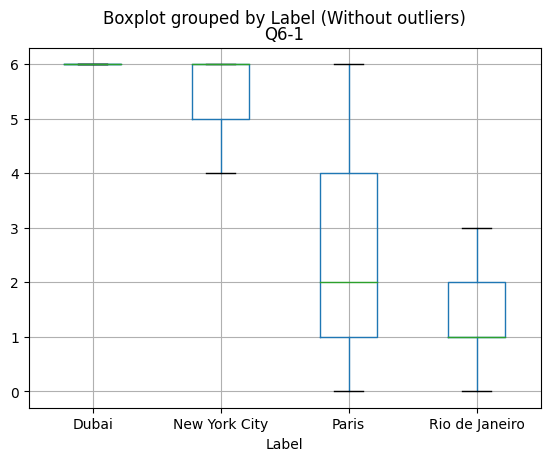

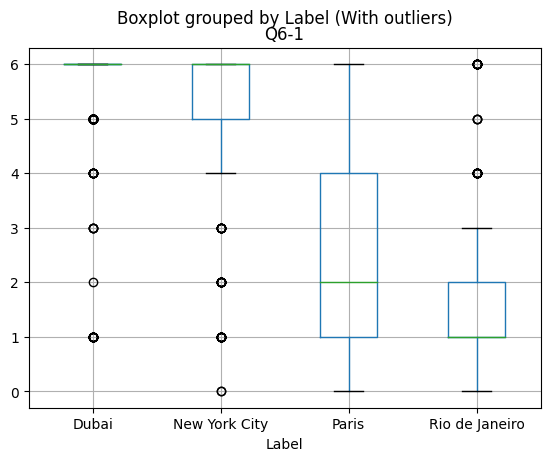

In [ ]:
# Q6 Skyscraper
get_stats("Q6-1")

Statistics for Q6-2
Dubai:			mean=2.482288828337875, median=2.0
Rio de Janeiro:		mean=5.0190735694822886, median=6.0
New York City:		mean=2.749318801089918, median=3.0
Paris:			mean=2.9182561307901906, median=3.0


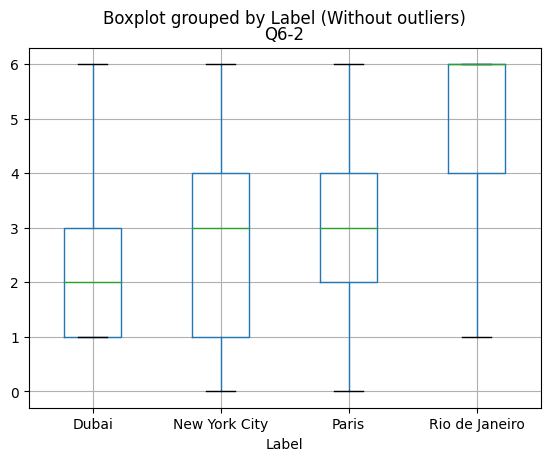

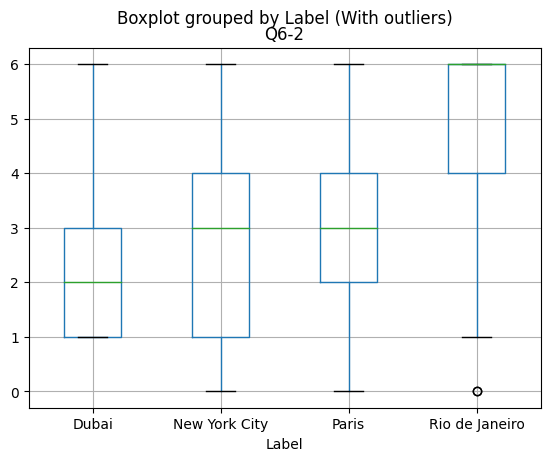

In [ ]:
# Q6 Sports
get_stats("Q6-2")

Statistics for Q6-3
Dubai:			mean=2.5885558583106265, median=2.0
Rio de Janeiro:		mean=4.446866485013624, median=5.0
New York City:		mean=3.683923705722071, median=4.0
Paris:			mean=5.15258855585831, median=6.0


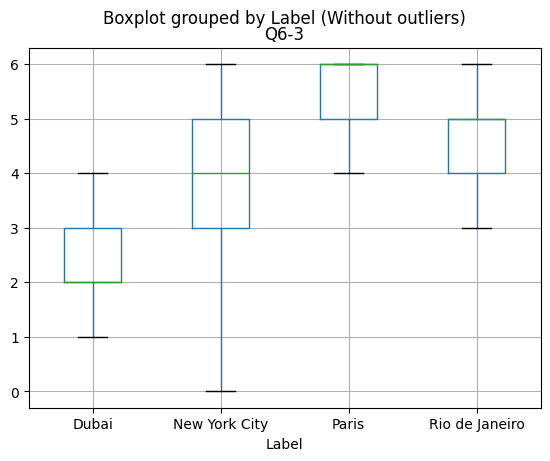

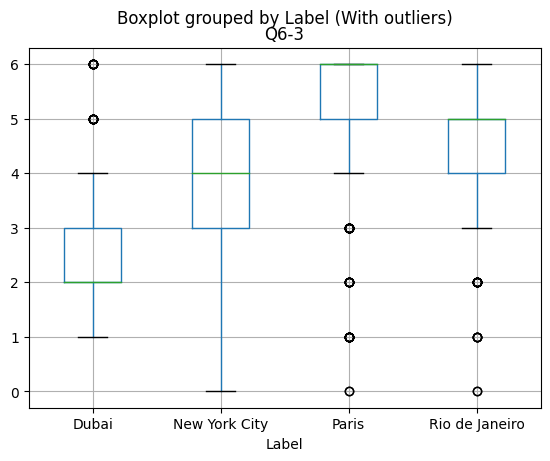

In [ ]:
# Q6 Arts and Music
get_stats("Q6-3")

Statistics for Q6-4
Dubai:			mean=2.5068119891008176, median=2.0
Rio de Janeiro:		mean=4.839237057220709, median=5.0
New York City:		mean=2.3896457765667574, median=2.0
Paris:			mean=2.869209809264305, median=3.0


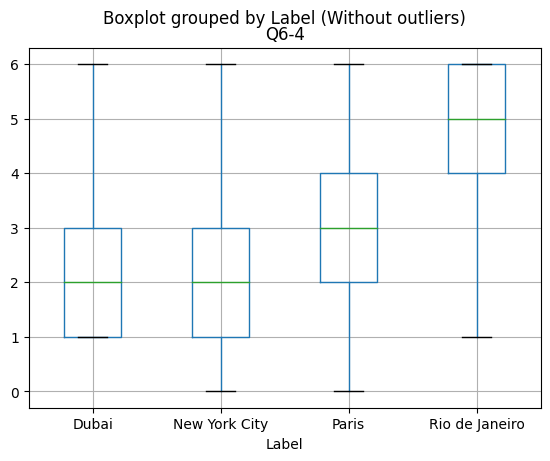

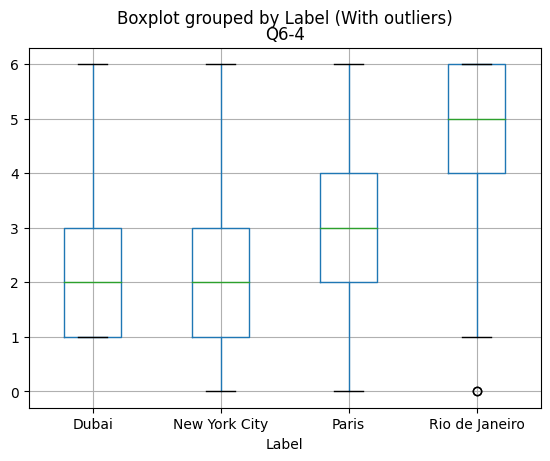

In [ ]:
# Q6 Carnival
get_stats("Q6-4")

Statistics for Q6-5
Dubai:			mean=3.449591280653951, median=4.0
Rio de Janeiro:		mean=3.3569482288828336, median=3.0
New York City:		mean=3.3896457765667574, median=3.0
Paris:			mean=4.8038147138964575, median=5.0


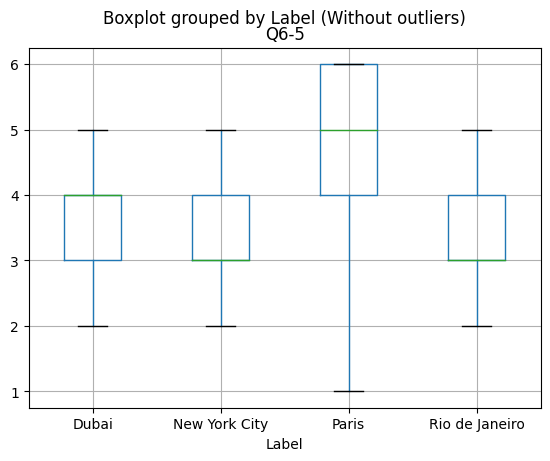

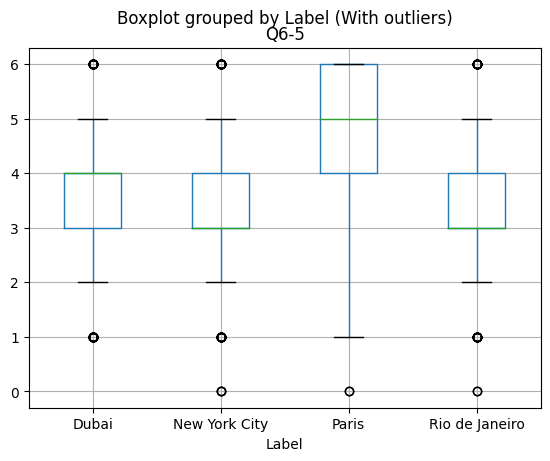

In [ ]:
# Q6 Cuisine
get_stats("Q6-5")

Statistics for Q6-6
Dubai:			mean=4.880108991825613, median=5.0
Rio de Janeiro:		mean=2.32425068119891, median=2.0
New York City:		mean=4.994550408719346, median=6.0
Paris:			mean=3.2779291553133514, median=3.0


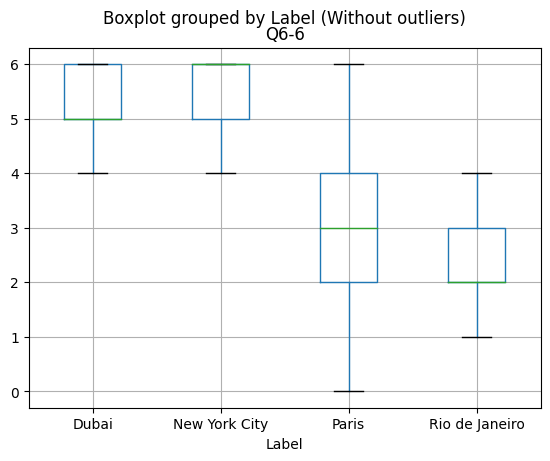

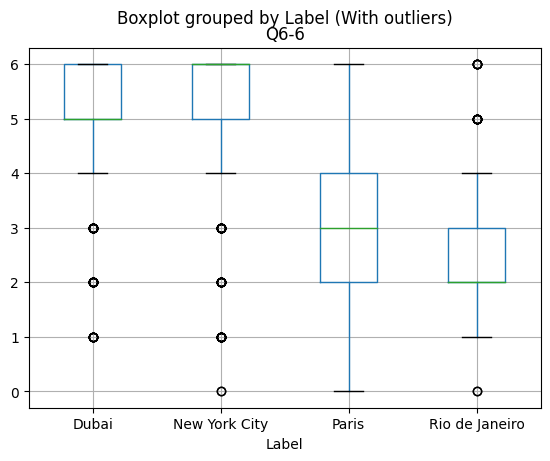

In [ ]:
# Q6 Economic
get_stats("Q6-6")

Statistics for Q7
Dubai:			mean=49.438692098092645, median=22.0
Rio de Janeiro:		mean=27.010899182561307, median=25.0
New York City:		mean=3.3583106267029974, median=3.0
Paris:			mean=6.863760217983652, median=5.0


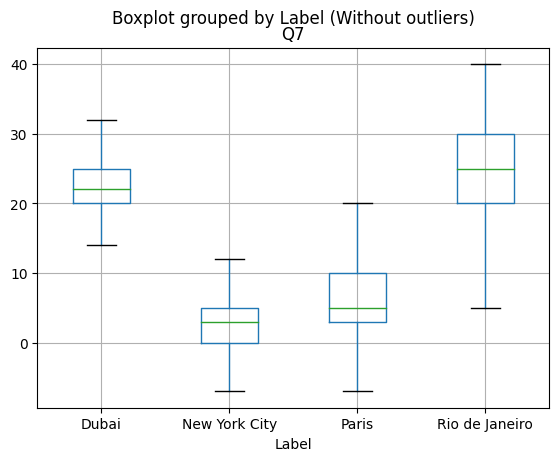

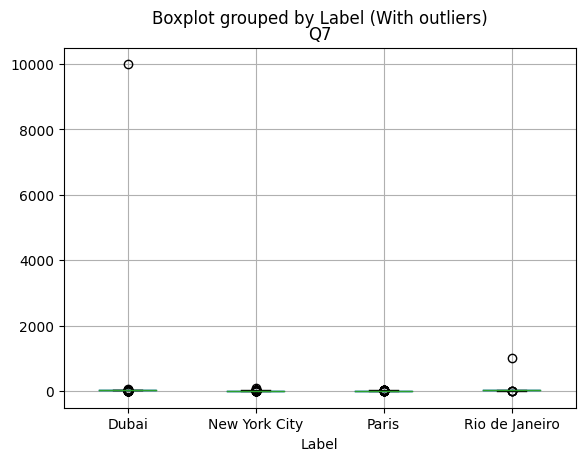

In [ ]:
# Q7
get_stats("Q7")

Statistics for Q8
Dubai:			mean=4.566757493188011, median=4.0
Rio de Janeiro:		mean=3.016348773841962, median=3.0
New York City:		mean=7.912806539509536, median=4.0
Paris:			mean=3.5967302452316074, median=3.0


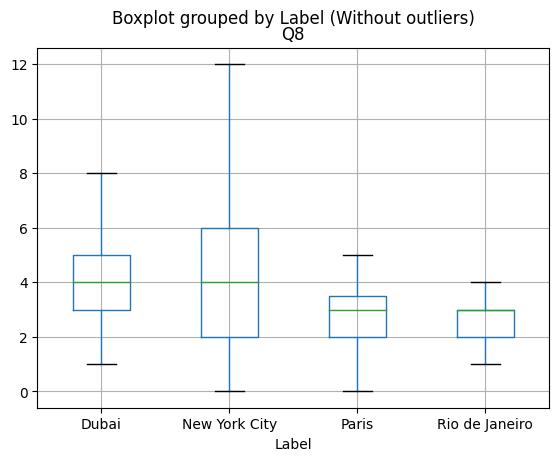

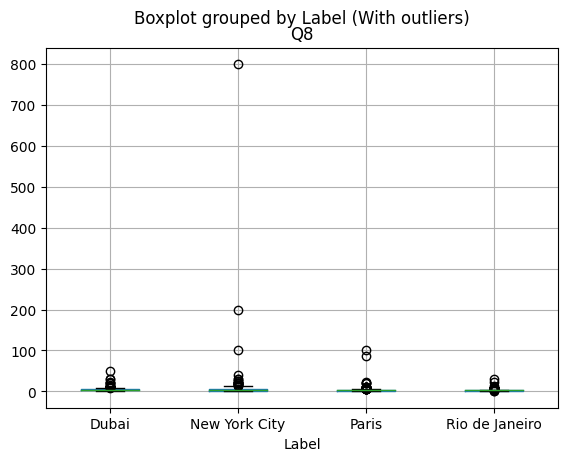

In [ ]:
# Q8
get_stats("Q8")

Statistics for Q9
Dubai:			mean=7.114441416893733, median=5.0
Rio de Janeiro:		mean=5.76566757493188, median=4.0
New York City:		mean=12.811989100817438, median=8.0
Paris:			mean=14.2425068119891, median=6.0


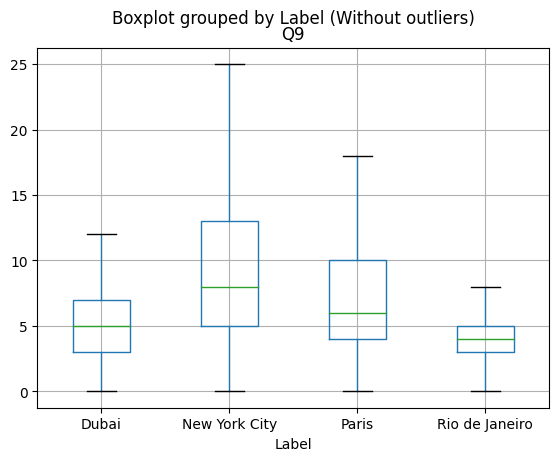

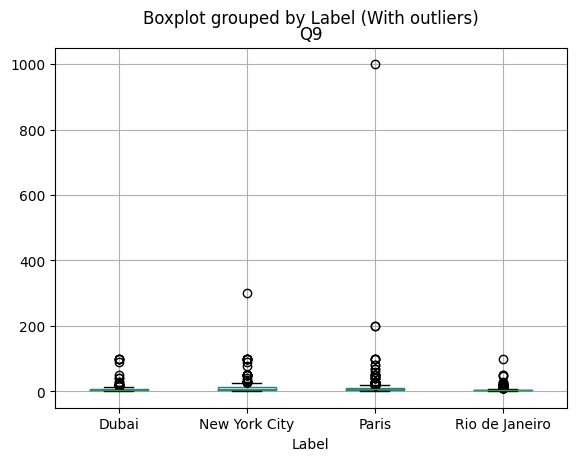

In [ ]:
# Q9
get_stats("Q9")

# Model Exploration

First we start by splitting the data into training, validation, and test set.

 We do so in a stratified fashion so the models are not trained with biased data. Allowing for proper representation of each class.

In [6]:
from sklearn.model_selection import train_test_split
# Split data into test, valid, and test set
X = data_fets
t = data_label
X_tv, X_test, t_tv, t_test = train_test_split(X, t, test_size=2/10, stratify=t)
X_train, X_valid, t_train, t_valid= train_test_split(X_tv, t_tv, test_size=2/10, stratify=t_tv)
unique, counts = np.unique(t_train, return_counts=True)
print(dict(zip(unique, counts)))

{'Dubai': 235, 'New York City': 235, 'Paris': 234, 'Rio de Janeiro': 235}


In [7]:
from sklearn.neighbors import KNeighborsClassifier

best_valid = 0
best_n = 0
best_test = 0
best_train = 0
random_state = random.randint(0, 1000)

for i in range(1, 20):
  clf = KNeighborsClassifier(n_neighbors=i)
  clf.fit(X_train, t_train)

  train_acc = clf.score(X_train, t_train)
  valid_acc = clf.score(X_valid, t_valid)
  test_acc = clf.score(X_test, t_test)

  if valid_acc > best_valid:
    best_valid = valid_acc
    best_n = i
    best_test = test_acc
    best_trian = train_acc

print(f"Best n_estimator: {best_n}")
print(f"Best train accuracy: {best_train}")
print(f"Best valid accuracy: {best_valid}")
print(f"Best test accuracy: {best_test}")


Best n_estimator: 3
Best train accuracy: 0
Best valid accuracy: 0.8297872340425532
Best test accuracy: 0.9149659863945578


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

best_valid = 0
best_test = 0
best_n = 0
best_train = 0
random_state = random.randint(0, 1000)

for i in range(7, 26):
  for j in range(5, 16):
    X = data_fets
    t = data_label
    X_tv, X_test, t_tv, t_test = train_test_split(X, t, test_size=2/10, stratify=t)
    X_train, X_valid, t_train, t_valid= train_test_split(X_tv, t_tv, test_size=2/10, stratify=t_tv)

    clf = RandomForestClassifier(n_estimators=i, max_depth=j, criterion="entropy", random_state=random_state)
    clf.fit(X_train, t_train)

    train_acc = clf.score(X_train, t_train)
    valid_acc = clf.score(X_valid, t_valid)
    test_acc = clf.score(X_test, t_test)

    if valid_acc > best_valid:
      best_valid = valid_acc
      best_n = i
      best_test = test_acc
      best_train = test_acc


print(best_valid)
print(best_test)

0.9531914893617022
0.8979591836734694


In [ ]:
from sklearn.neural_network import MLPClassifier
import os

x = []
y = []
best_valid = 0
best_test = 0
best_n = 0
best_train = 0
random_state = random.randint(0, 1000)
coef = None


for i in range(1, 100):
  clf = MLPClassifier(hidden_layer_sizes=(i,), activation="tanh", solver="sgd", max_iter=5000)
  clf.fit(X_train, t_train)

  train_acc = clf.score(X_train, t_train)
  valid_acc = clf.score(X_valid, t_valid)
  test_acc = clf.score(X_test, t_test)

  x.append(i)
  y.append(valid_acc)

  if valid_acc > best_valid:
    best_valid = valid_acc
    best_n = i
    best_test = test_acc
    best_train = train_acc
    coef = clf.coefs_

print(f"Best n_estimator: {best_n}")
print(f"Best train accuracy: {best_train}")
print(f"Best valid accuracy: {best_valid}")
print(f"Best test accuracy: {best_test}")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
total_v_r = 0
total_t_r = 0

total_v_t = 0
total_t_t = 0

total_v_l = 0
total_t_l = 0
for j in range(10):
  # Split data into test, valid, and test set
  X_tv, X_test, t_tv, t_test = train_test_split(X, t, test_size=2/10, stratify=t)
  X_train, X_valid, t_train, t_valid= train_test_split(X_tv, t_tv, test_size=2/10, stratify=t_tv)

  # Tuning hyperparameters
  best_train = 0
  best_valid = 0
  best_test = 0
  best_n = 0
  coef = None
  intercept = None

  for i in range(10, 101, 10):
    print(f"Training model with {i} neurons...")
    clf = MLPClassifier(hidden_layer_sizes=(i,), activation="relu", solver="sgd", max_iter=5000)
    clf.fit(X_train, t_train)

    train_acc = clf.score(X_train, t_train)
    valid_acc = clf.score(X_valid, t_valid)
    test_acc = clf.score(X_test, t_test)

    if valid_acc > best_valid:
      best_test = test_acc
      best_valid = valid_acc
      best_train = train_acc
      best_n = i
      coef = clf.coefs_.copy()
      intercept = clf.intercepts_.copy()

  print(f"Training complete\n")
  total_v_r += best_valid
  total_t_r += best_test

  # Tuning hyperparameters
  best_train = 0
  best_valid = 0
  best_test = 0
  best_n = 0
  coef = None
  intercept = None

  for i in range(10, 101, 10):
    print(f"Training model with {i} neurons...")
    clf = MLPClassifier(hidden_layer_sizes=(i,), activation="tanh", solver="sgd", max_iter=5000)
    clf.fit(X_train, t_train)

    train_acc = clf.score(X_train, t_train)
    valid_acc = clf.score(X_valid, t_valid)
    test_acc = clf.score(X_test, t_test)

    if valid_acc > best_valid:
      best_test = test_acc
      best_valid = valid_acc
      best_train = train_acc
      best_n = i
      coef = clf.coefs_.copy()
      intercept = clf.intercepts_.copy()

  print(f"Training complete\n")
  total_v_t += best_valid
  total_t_t += best_test

  # Tuning hyperparameters
  best_train = 0
  best_valid = 0
  best_test = 0
  best_n = 0
  coef = None
  intercept = None

  for i in range(10, 101, 10):
    print(f"Training model with {i} neurons...")
    clf = MLPClassifier(hidden_layer_sizes=(i,), activation="logistic", solver="sgd", max_iter=5000)
    clf.fit(X_train, t_train)

    train_acc = clf.score(X_train, t_train)
    valid_acc = clf.score(X_valid, t_valid)
    test_acc = clf.score(X_test, t_test)

    if valid_acc > best_valid:
      best_test = test_acc
      best_valid = valid_acc
      best_train = train_acc
      best_n = i
      coef = clf.coefs_.copy()
      intercept = clf.intercepts_.copy()

  print(f"Training complete\n")
  total_v_l += best_valid
  total_t_l += best_test

print(f"Average valid relu: {total_v_r/10}")
print(f"Average test relu: {total_t_r/10}\n")

print(f"Average valid tanh: {total_v_t/10}")
print(f"Average test tanh: {total_t_t/10}\n")

print(f"Average valid logistic: {total_v_l/10}")
print(f"Average test logistic: {total_t_l/10}\n")
